## RNN and LSTM 

LSTM公式

$$ i = \sigma(W_{ii}x + b_{ii} + W_{hi} h + b_{hi})$$
$$ f = \sigma(W_{if}x + b_{if} + W_{hf}h + b_{hf})$$
$$ g = tanh(W_{ig}x + b_{ig} + W_{hg}h + b_{hg})$$
$$ o = \sigma(W_{io}x + b_{io} + W_{ho}h + b_{ho})$$
$$ c' = f * c + i * g$$
$$ h' = o * tanh(c')$$

简单来说，LSTM一共有三个门，输入门，遗忘门，输出门，$i,f,o$分别为三个门的程度参数，$g$是对输入的常规RNN操作。公式里可以看到LSTM的输出有两个，cell state $c'$和hidden state $h'$，$c'$是经输入、遗忘门的产物，也就是当前cell本身的内容，经过输出门得到$h'$，就是想输出什么内容给下一个单元。

实际应用时，我们并不关心cell本身的状态，而是要拿到它呈现出的状态$h'$作为最终输出。

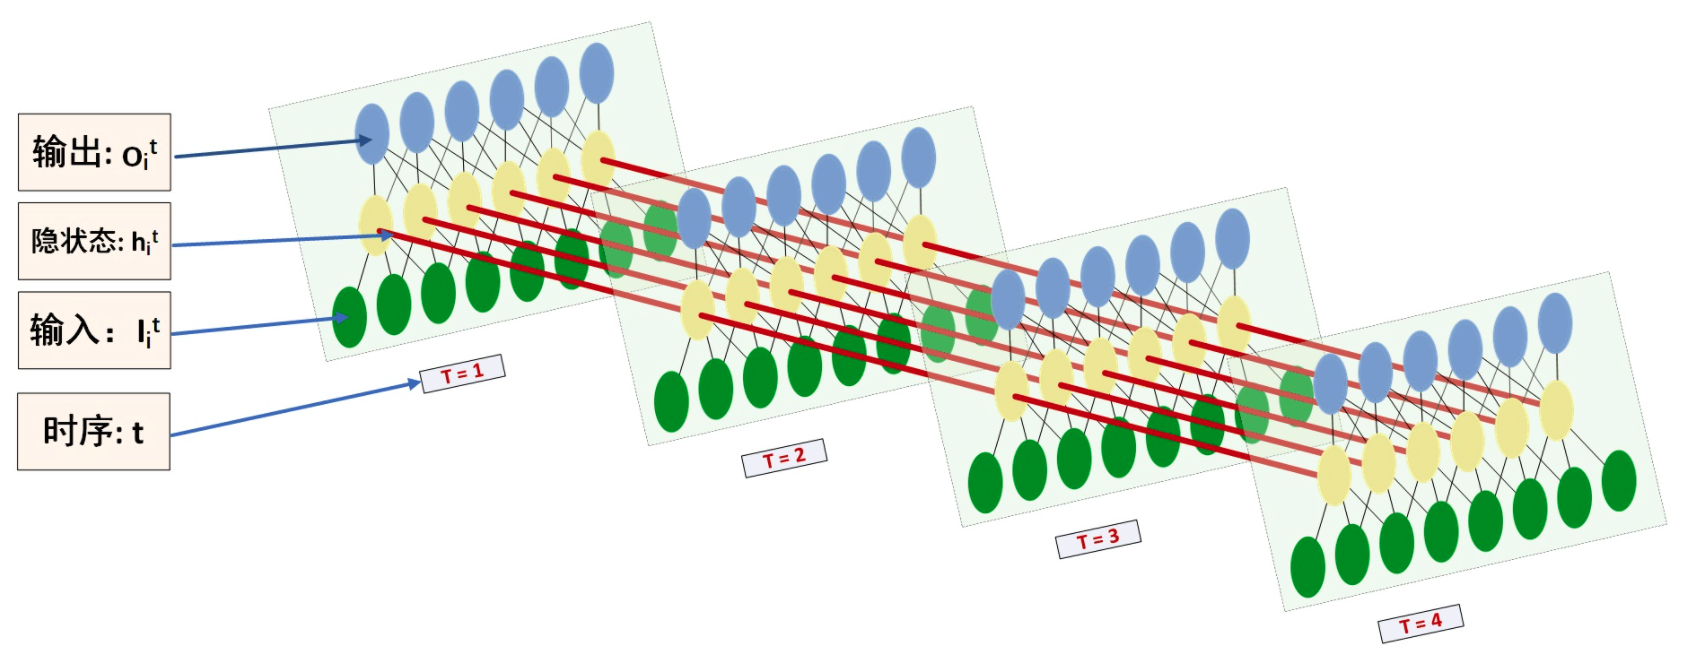

这张图时一MLP的形式展示LSTM的传播方式，方便理解hidden_size这个参数。其实hidden_size在各个函数里含义都差不多，就是参数W的第一维（或最后一维）。那么对应前面公式，hidden_size实际上就是以这个size设置所有W的对应维。

每个时序t的输入$I_i^t$是一次time_step,一张input tensor, 隐状态$h_i^t$则代表MLP的hidden layer的一个cell.输出为$o_i^t$.注意，红色箭头indicates the tensor's flow at time-sequential order.


再结合一个操作实例说明。如果我有一条长文本，我给句子事先分割好句子，并且进行tokenize, dictionarize,接着再由look up table 查找到embedding，将token由embedding表示，再对应到上图的输入。流程如下：

`step1, raw text:  `
接触LSTM模型不久，简单看了一些相关的论文，还没有动手实现过。然而至今仍然想不通LSTM神经网络究竟是怎么工作的。……     

`step2, tokenize (中文得分词):  `   
`sentence1:  接触 LSTM 模型 不久 ，简单 看了 一些 相关的 论文 ， 还 没有 动手 实现过 。`    
`sentence2: 然而 至今 仍然 想不通 LSTM 神经网络 究竟是 怎么 工作的。 `   
……

`step3, dictionarize:`    
`sentence1: 1 34 21 98 10 23 9 23  `   
`sentence2: 17 12 21 12 8 10 13 79 31 44 9 23  `   
…… 

`step4, padding every sentence to fixed length:   `   
`sentence1: 1 34 21 98 10 23 9 23 0 0 0 0 0 `  
`sentence2: 17 12 21 12 8 10 13 79 31 44 9 23  0  ` 
……

`step5, mapping token to an embeddings:  `
`sentence1:`

$$
 \left[
 \begin{matrix}
   0.341 & 0.133 & 0.011 & ... \\
   0.435 & 0.081 & 0.501 & ... \\
   0.013 & 0.958 & 0.121 & ... \\
   ... & ... & ... & ...\\
  \end{matrix}
  \right] \tag{3}
$$

`每一列代表一个词向量，词向量维度自行确定；矩阵列数固定为time_step length。 ` 
`sentence2:  `   
……

`step6, feed into RNNs as input: `

`假设 一个RNN的time_step 确定为`$l$`,则padded sentence length(step5中矩阵列数)固定为`$l$`。一次RNNs的run只处理一条sentence。每个sentence的每个token的embedding对应了每个时序t的输入`$I_i^t$`。一次RNNs的run，连续地将整个sentence处理完。`

`step7, get output:`     
`看图，每个time_step都是可以输出当前时序t的隐状态`$h_i^t$ `；但整体RNN的输出`$o_i^t$`是在最后一个time_step`$t=l$`时获取，才是完整的最终结果。`

`step8, further processing with the output:`       
`我们可以将output根据分类任务或回归拟合任务的不同，分别进一步处理。比如，传给cross_entropy&softmax进行分类……或者获取每个time_step对应的隐状态  ，做seq2seq 网络……或者搞创新……`

用torch.nn模块搭建的模型是一个layer, 用torch.nn.function模块搭建的模型是函数。

`torch.nn.lstm(input_size,hidden_size,num_layers,bias,batch_first,dropout,bidirectional)`

**参数**

* input_size==embedding_size即输入的隐层维度
* hidden_size,lstm模型参数维度
* num_layers,有几层LSTM
* bias: 隐层状态是否带bias，默认为true。bias是偏置值，或者偏移值。没有偏置值就是以0为中轴，或以0为起点。偏置值的作用请参考单层感知器相关结构。
* batch_first: 输入输出的第一维是否为 batch_size，默认值 False。因为 Torch 中，人们习惯使用Torch中带有的dataset，dataloader向神经网络模型连续输入数据，这里面就有一个 batch_size 的参数，表示一次输入多少个数据。 在 LSTM 模型中，输入数据必须是一批数据，为了区分LSTM中的批量数据和dataloader中的批量数据是否相同意义，LSTM 模型就通过这个参数的设定来区分。 如果是相同意义的，就设置为True，如果不同意义的，设置为False。 torch.LSTM 中 batch_size 维度默认是放在第二维度，故此参数设置可以将 batch_size 放在第一维度。如：input 默认是(4,1,5)，中间的 1 是 batch_size，指定batch_first=True后就是(1,4,5)。所以，如果你的输入数据是二维数据的话，就应该将 batch_first 设置为True;
* dropout: 默认值0。是否在除最后一个 RNN 层外的其他 RNN 层后面加 dropout 层。输入值是 0-1 之间的小数，表示概率。0表示0概率dripout，即不dropout
* bidirectional: 是否是双向 RNN，默认为：false，若为 true，则：num_directions=2，否则为1。

**输入**

* input:(seq_len, batch, input_size)
* h_0:(num_layers * num_directions, batch, hidden_size)
* c_0:(num_layers * num_directions, batch, hidden_size)

**输出**

* output:(seq_len, batch, num_directions * hidden_size)
* h_n:(num_layers * num_directions, batch, hidden_size)
* c_n:(num_layers * num_directions, batch, hidden_size)


这张图非常便于理解num_layers.实际上就是depth堆叠，每个蓝色块都是LSTM单元，只不过第一层输入是$x_t, h_{t-1}^{(0)},c_{t-1}^{(0)}$，中间层输入是$h_t^{(k-1)},h_{t-1}^{(k)},c_{t-1}^{(k)}$.

再看一张很好的图
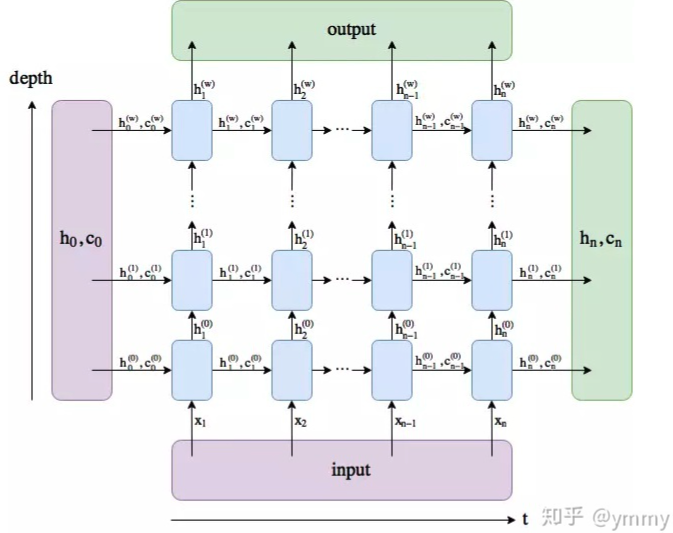

output就是最后一个layer上，序列中每个时刻（横向）状态h的集合（若为双向则按位置拼接，输出维度2\*hidden_size），而$h_n$实际上是每个layer最后一个状态（纵向）输出的拼接。

也就是说对于单向LSTM来说，$h_n[-1,:,:]$就是$output[-1,:,:]$，相当于序列最后一个时间步的输出。如果使用LSTM的目的是得到整个序列embedding,与序列长度无关，由于LSTM具有序列信息传递性，因此一般可以取$h_n[-1,:,:]$当作序列embedding。但双向LSTM推广后，每个时间步的隐层输出都可以作为当前词的一个融合了上下文的embedding，因此BiLSTM可以视为一种词级别的encoder方法，得到的output既可以用于词级别的输出拼接，也可以进行融合（比如attention加权求和、pooling）得到序列级的输出。

解释下batch_first参数？为什么要有batch_first这个参数呢？常规的输入不就是(batch, seq_len, hidden_size)吗？而且参数默认为False，也就是它鼓励你第一维不是batch，更奇怪了。

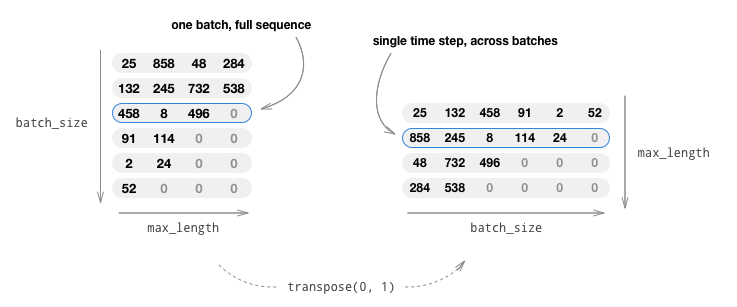

左边是我们的常规输入（先不考虑hidden dim，每个数字代表序列中的一个词），右边是转置后，第一维成了max_length。我们知道在操作时第一维一般可视为“循环”维度，因此左边一个循环项是一个序列，无法同时经LSTM处理，而右边跨batch的循环项相当于当前time step下所有序列的当前词，可以并行过LSTM。（当然不管你是否batch_first它都是这么处理的，这个参数应该只是提醒一下这个trick）

In [1]:
import torch
import torch.nn as nn

#输入维度为10,隐藏层神经元个数为20,总共有2个隐藏层
lstm = nn.LSTM(10, 20, 2)  #实例化  括号里的参数(input_size,hidden_size,num_layers)  

# batch_size=3,每个句子有5个词，每个词用10维向量表示
x = torch.randn(5, 3, 10)  # 准备输入张量,    括号里的参数(seq_len,batch,input_size)

# hidden的初始状态
h0 = torch.randn(2, 3, 20) # hidden初始状态,括号里的参数(num_layers*num_directions, batch, hidden_size)

# cell的初始状态
c0 = torch.randn(2, 3, 20) # cell初始状态,  括号里的参数(num_layers * num_directions, batch, hidden_size)
output , (hn, cn) = lstm(x, (h0, c0))

In [2]:
output.shape

torch.Size([5, 3, 20])

In [3]:
hn.shape

torch.Size([2, 3, 20])

In [4]:
cn.shape

torch.Size([2, 3, 20])